# Causal analysis with PyMC: Answering "What If?" with the new `do` operator

Authors: [Benjamin T. Vincent](https://github.com/drbenvincent) & [Thomas Wiecki](https://github.com/twiecki)

## Why Causal Analysis?

Causal analysis is rapidly gaining popularity, but why?

Without a causal understanding of the world, it's often impossible to identify which actions lead to a desired outcome. For example, if you wanted to cool down on a hot summer day, you would not put your thermometer into an ice bath to make the temperature go down. The obvious reason is that you know that the temperature affects the thermometer, but not the other way around.

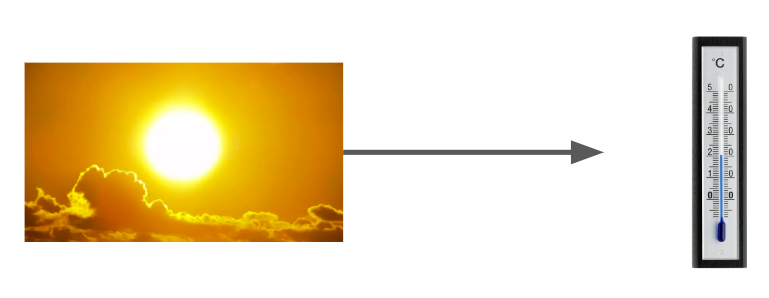

In business, we are constantly taking actions to achieve a certain outcome (e.g. increase sales). So in order not to waste our time heating our proverbial thermometer, we need a solid understanding of the *causal relationships* underlying our business processes. This is the premise of *Decision Intelligence*.

Machine learning methods might help us *predict* what's going to happen with great accuracy, but what's the value of that if it doesn't tell us *what to do* to achieve a desirable outcome.

## Why Bayesian Causal Analysis?

Causal analysis is often embedded in a frequentist framework, which comes with some well-documented baggage (see e.g. [Scientists rise up against statistical significance](https://www.nature.com/articles/d41586-019-00857-9)).

It is sometimes claimed that Bayesian statistics does not allow for causal analysis. However, as we will demonstrate in this blog post, this is wrong. Combining these two fields provides many benefits over traditional causal analysis.

## Why Bayesian Causal Analysis *in PyMC*?
PyMC is a mature and highly scalable Python package for building Bayesian models using an approachable syntax. Rather than invent new frameworks for performing structural causal analysis, we can super-charge PyMC for Bayesian Causal Analysis with a powerful feature: **the new do operator**.

Note that we are specifically focusing on Structural Causal Modeling here, rather than e.g. quasi-experimentation which is the focus of packages like [`CausalPy`](https://causalpy.readthedocs.io/).

In sum, there are several advantages compared to more traditional frequentist causal inference approaches:

* Frequentist statistics has well-known pratical issues that make it prone to misuse (p-hacking etc).
* PyMC is a well-established tool that allows building and inference of highly sophisticated models.
* If you already have a PyMC model, now you can do scenario anaysis and ask "What If" questions natively.

## Setting up

In [1]:
!pip install pymc daft seaborn

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.5/488.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.6 MB/s eta 0:00:00
  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9098 sha256=2e12840530461648c9f1407b87996beed9151cea63a3630cea190f522c984bdc
  Stored in directory: /root/.cache/pip/wheels/a4/11/f5/8265470e17d280d8b5910e1b0f298521420a5086d696e96799
  Created wheel for logical-unification: filename=logical_unification-0.4.6-py3-none-any.whl size=13911 sha256=044c314f9e149a91fb30c84e73dffd64f76b161eb4e6db966d824fafede5a9d4
  Stored in directory: /root/.cache/pip/wheels/ba/95/1f/29d557452d7f5102769de

In [2]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor as pt
import seaborn as sns
from packaging import version

In [3]:
# check we have the required versions
assert version.parse(pm.__version__) >= version.parse("5.8.0")

In [4]:
# import the new functionality
from pymc import do, observe

In [5]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = [10, 6]
SEED = 42
sns.set_theme(context="notebook", style="white")

## Example: Estimating impact of Google Ads with TV as a confounder

The marketing team of our e-commerce company comes to us with a simple request: Estimate the effectiveness of the paid Google search ads in driving sales.

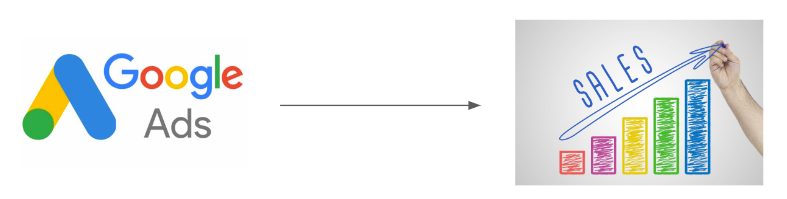

Pretty simple, right? We just correlate how much we're spending on search ads with our sales volume. If we wanted to get fancy, we could use a Bayesian Marketing-Mix Model or train a machine-learning model for this.

There is just one complication: unbeknownst to us, the marketing team is also running TV ad campaigns. In order to maximize the impact of the TV ads, the marketing team is turning google search ads on when TV ads are active, but when there are no TV campaigns, Google ads are turned off to save on marketing budget.

Thus our situation looks actually like this:

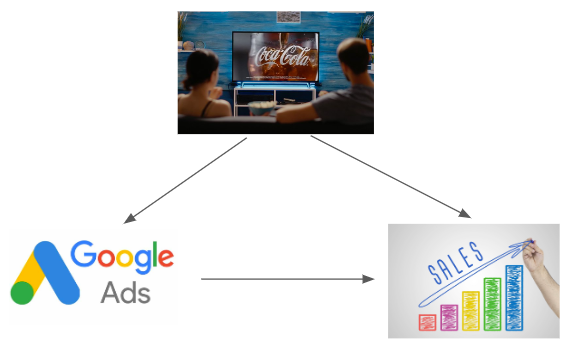

In causal inference terms, we're dealing with a **confounder** -- TV influences both: sales *and* Google ad spend. This is potentially highly problematic, because it's totally possible that it only looks like Google ads increase sales, but that this effect is completely driven by the TV ads increasing search volume and that there is in fact *no causal effect of Google Ads on sales*. 

This example illustrates well why we really care about making *causal* claims about our data. Who cares if Google ad spend is *correlated* with sales or is very predictive, what we really want to know is what actions we should take to increase sales.

### Formalizing the underlying Bayesian Causal Network

We can represent the above example with an idiomatic causal directed acyclic graph (DAG) where we have a binary treatment variable $Z$ (Google ads on/off) which may or may not causally influence an outcome $Y$ (sales). However, this relationship suffers from confounding by $C$ (TV) which causally influences both treatment and outcome. Further, we turn this into a Bayesian causal DAG by specifying probabilistic causal relationships between the nodes. A prior is placed on $C$ as it has no parent nodes.

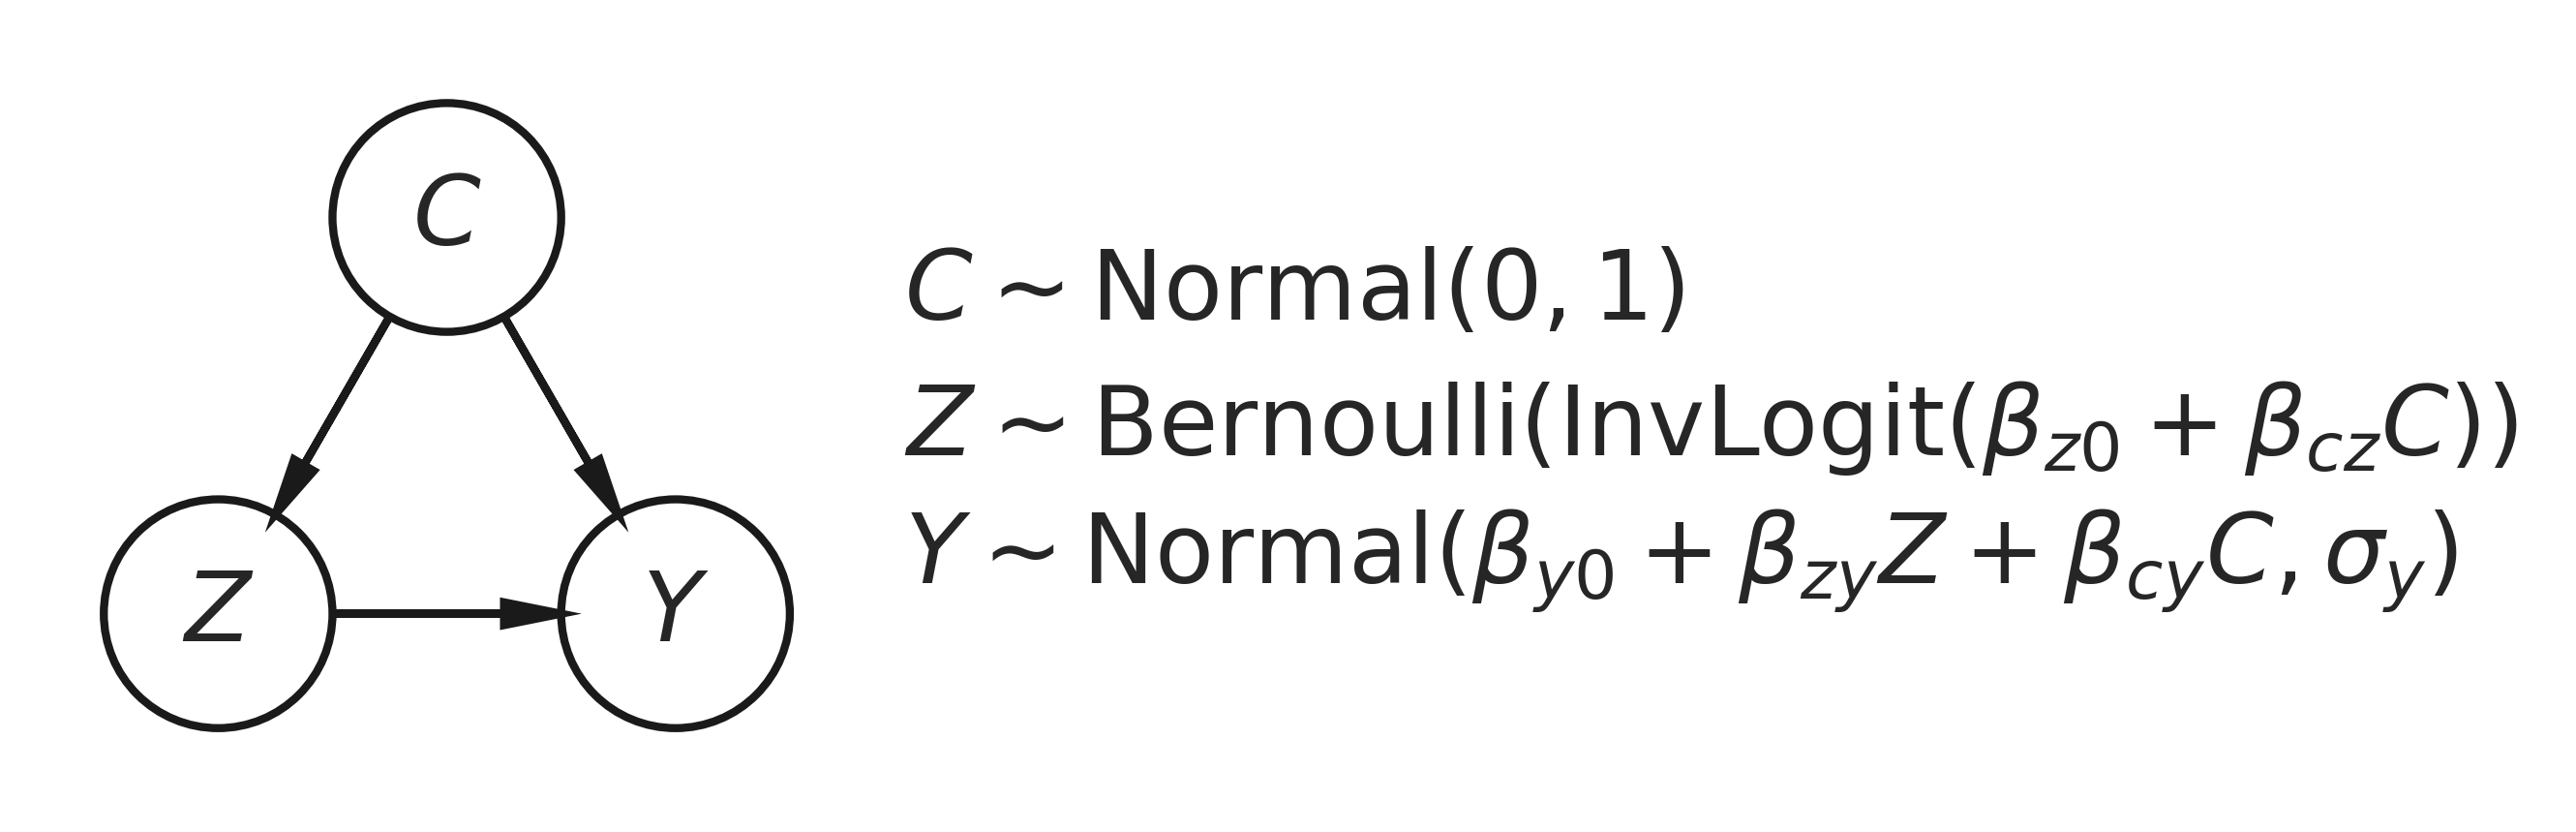

In [6]:
pgm = daft.PGM()
pgm.add_node("y", "$Y$", 0, 0)
pgm.add_node("z", "$Z$", -1, 0)
pgm.add_node("c", "$C$", -0.5, 0.866)
pgm.add_edge("z", "y")
pgm.add_edge("c", "y")
pgm.add_edge("c", "z")
pgm.add_text(0.5, 0.6, r"$C \sim \mathrm{Normal}(0, 1)$")
pgm.add_text(
    0.5,
    0.3,
    r"$Z \sim \mathrm{Bernoulli}(\operatorname{InvLogit}(\beta_{z0} + \beta_{cz} C))$",
)
pgm.add_text(
    0.5,
    0,
    r"$Y \sim \mathrm{Normal}(\beta_{y0} + \beta_{zy} Z + \beta_{cy} C, \sigma_y)$",
)
pgm.render(dpi=300);

As you can see, we are essentially setting up two regressions: a logistic regression of $C$ on $Z$, and a linear regression of $C$ *and* $Z$ on $Y$, all with the appropriate intercepts and regression coefficients.

Because our main relationship of interest here is between the treatment $Z$ and the outcome $Y$, we can see that this example corresponds to the idiomatic _confounded relationship_.

Our goal in this example is to establish the strength of the $Z \rightarrow Y$ causal relationship, expressed as parameter $\beta_{ZY}$. Assuming this is an accurate and complete causal story of our data (a big assumption!) we can quantify the uplift on sales that is caused by paid search.

Note that in this blog post we assume we already know the causal graph. Where that is not the case, we need to look towards methods of [causal discovery](https://en.wikipedia.org/wiki/Exploratory_causal_analysis).

Before we dive in to the code, let's specify some notation to make life a bit simpler:
* We have random variables $C$, $Z$, and $Y$
* These are different from observations, specific values, $c$, $z$, and $y$
* We have a set of latent parameters, $\theta = \{ \beta_{z0}, \beta_{y0}, \beta_{zy}, \beta_{cy}, \beta_{cz}, \sigma_{y} \}$

### Define the full data generating process in a PyMC model, $P(C, Z, Y, \theta)$

This next step may seem slightly alien to many existing PyMC users. We are going to define an 'empty' model, not conditioned on any data at all. This can be thought of as a 'pure' description of our data generating process, totally divorced from any actual data.

/opt/conda/lib/python3.10/site-packages/pymc/model/core.py:538: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pymc/model/core.py:1003: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(


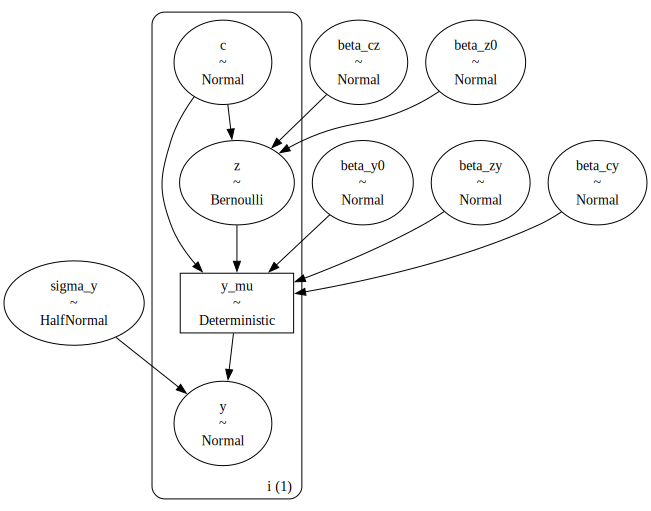

In [7]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- C -> Z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on Z -> Y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

pm.model_to_graphviz(model_generative)

### Simulating data

Having defined the full joint distribution, we are first going to use it to generate simulated data with known effect sizes, to then test if we can recover them. 

In order to do that, we are going to specify some true parameter values that govern the causal relationships between nodes. Importantly, we will set the true causal influence of $Z$ upon $Y$ to be equal to 0, that is $\beta_{zy}=0$. This is known as the true [Average Treatment Effect (ATE)](https://en.wikipedia.org/wiki/Average_treatment_effect). If you recall our real-world example, this would correspond to Google ads having no causal effect on sales.

Of course, in real-world situations we will not know what the true ATE is. We only know it here because we are simulating the data and know the ground truth. Our goal is to estimate what the ATE is, and testing how well we can infer known parameters from the data alone (an excercise called Parameter Recovery) is a very useful excercise. If we can't recover the parameters in a simple toy simulated world, then we shouldn't have much faith that we can estimate the true effects in more complex real-world dataset.

While there are other ways to do this, here **we will use the new `do` operator to generate a new model with the parameters set to certain values**.

In [8]:
true_ATE = 0.0

true_values = {
    "beta_z0": 0.0,
    "beta_y0": 0.0,
    "beta_cz": 1.5,
    "beta_zy": true_ATE,
    "beta_cy": 1.0,
    "sigma_y": 0.2,
}

model_simulate = do(model_generative, true_values)

Let's unpack this a little bit. The `do`-function takes a `pymc.Model` object and a dict of parameter values. It then returns a *new* model where the original random variables (RVs) have been converted to constant nodes taking on the specified values. 

But we're just warming up here, a bit further below, we'll see a much cooler application of the `do`-operator.

Next, we'll sample from this new model to obtain samples from distibution $P(C, Z, Y | \theta)$. Note that we'll use `pm.sample_prior_predictive` (not `pm.sample` because we are not doing any inference).

In [9]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=SEED)

observed = {
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten(),
    "z": simulate.prior["z"].values.flatten(),
}

df = pd.DataFrame(observed).sort_values("c", ascending=False)

If we just did the basic analysis of what our sales ($y$) look like based on google ads being turned on ($z=1$) or off ($z=0$), then it looks like there's a big difference:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


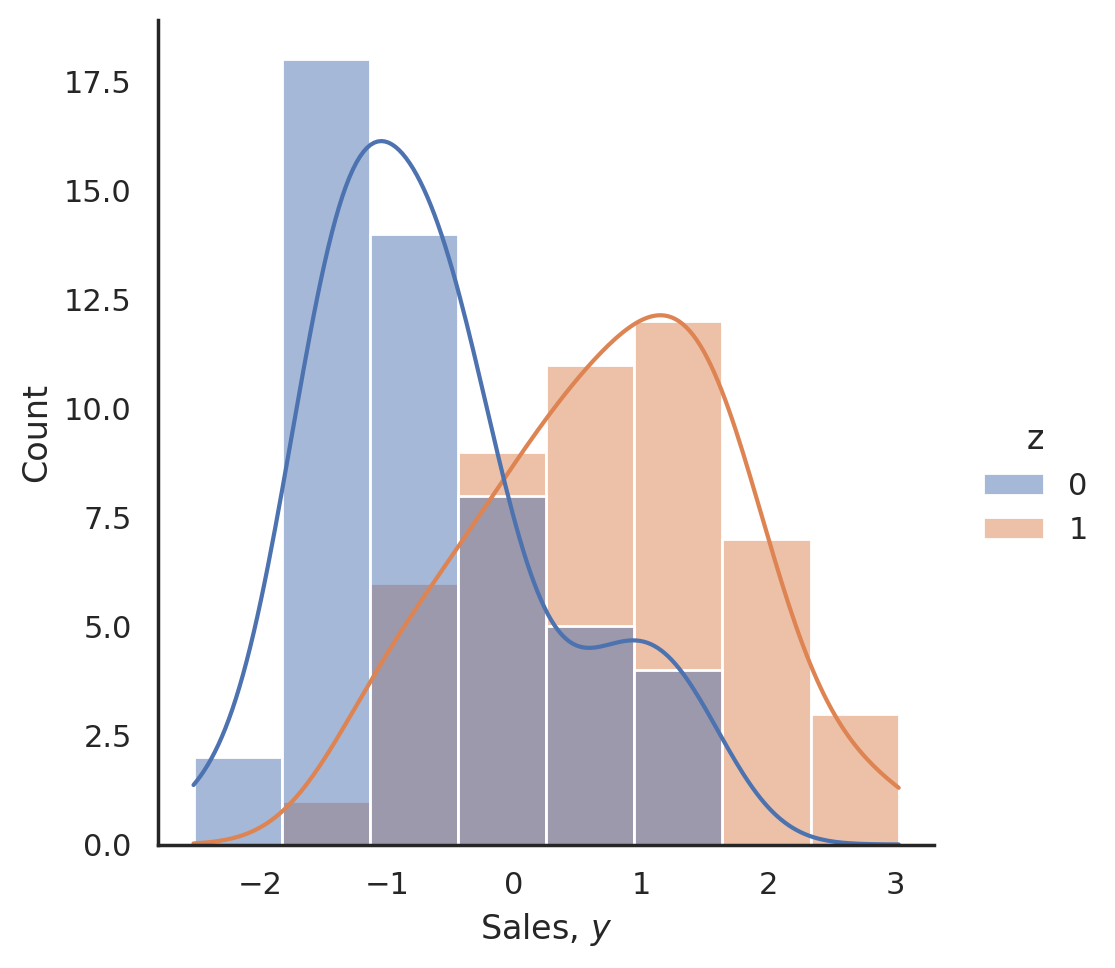

In [10]:
ax = sns.displot(data=df, x="y", hue="z", kde=True)
ax.set(xlabel="Sales, $y$");

We could further confirm a significant effect of Google ads on sales using a t-test or Bayesian significance test but will skip that for now as it's fairly obvious that there is a large difference between the two groups.

**The key point is that in our setup, while it looks like Google Ads has a big (positive) influence on sales, there is actually no underlying *causal* effect between them. The difference we see is entirely driven by the TV confounder.**

### Inferring model parameters, $P( \theta | c, z, y)$

Let's next turn to inference. For that, we could just redefine the above model and use the `observed` kwarg as is common in PyMC.

However, we can do something a bit cooler than that and use another new function called `observe()`. This function takes a model and data, and returns a new model with the data set as `observed` on our target RV, similar to the `do()` function. 

Importantly, we want to derive this observed model from our original "empty" `model_generative` from above, so that no parameters are fixed in place.

In [11]:
model_inference = observe(model_generative, {"c": df["c"], "y": df["y"], "z": df["z"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))

Now we can press the Inference Button(TM) and sample from our posterior as if we had defined our model in the classic way.

In [12]:
with model_inference:
    idata = pm.sample(random_seed=SEED)

Output()

We can inspect our posterior distributions using `arviz`. By plotting the known parameter values we used to generate the simulated data, we can confirm that the inference step has done a good job of estimating these values.

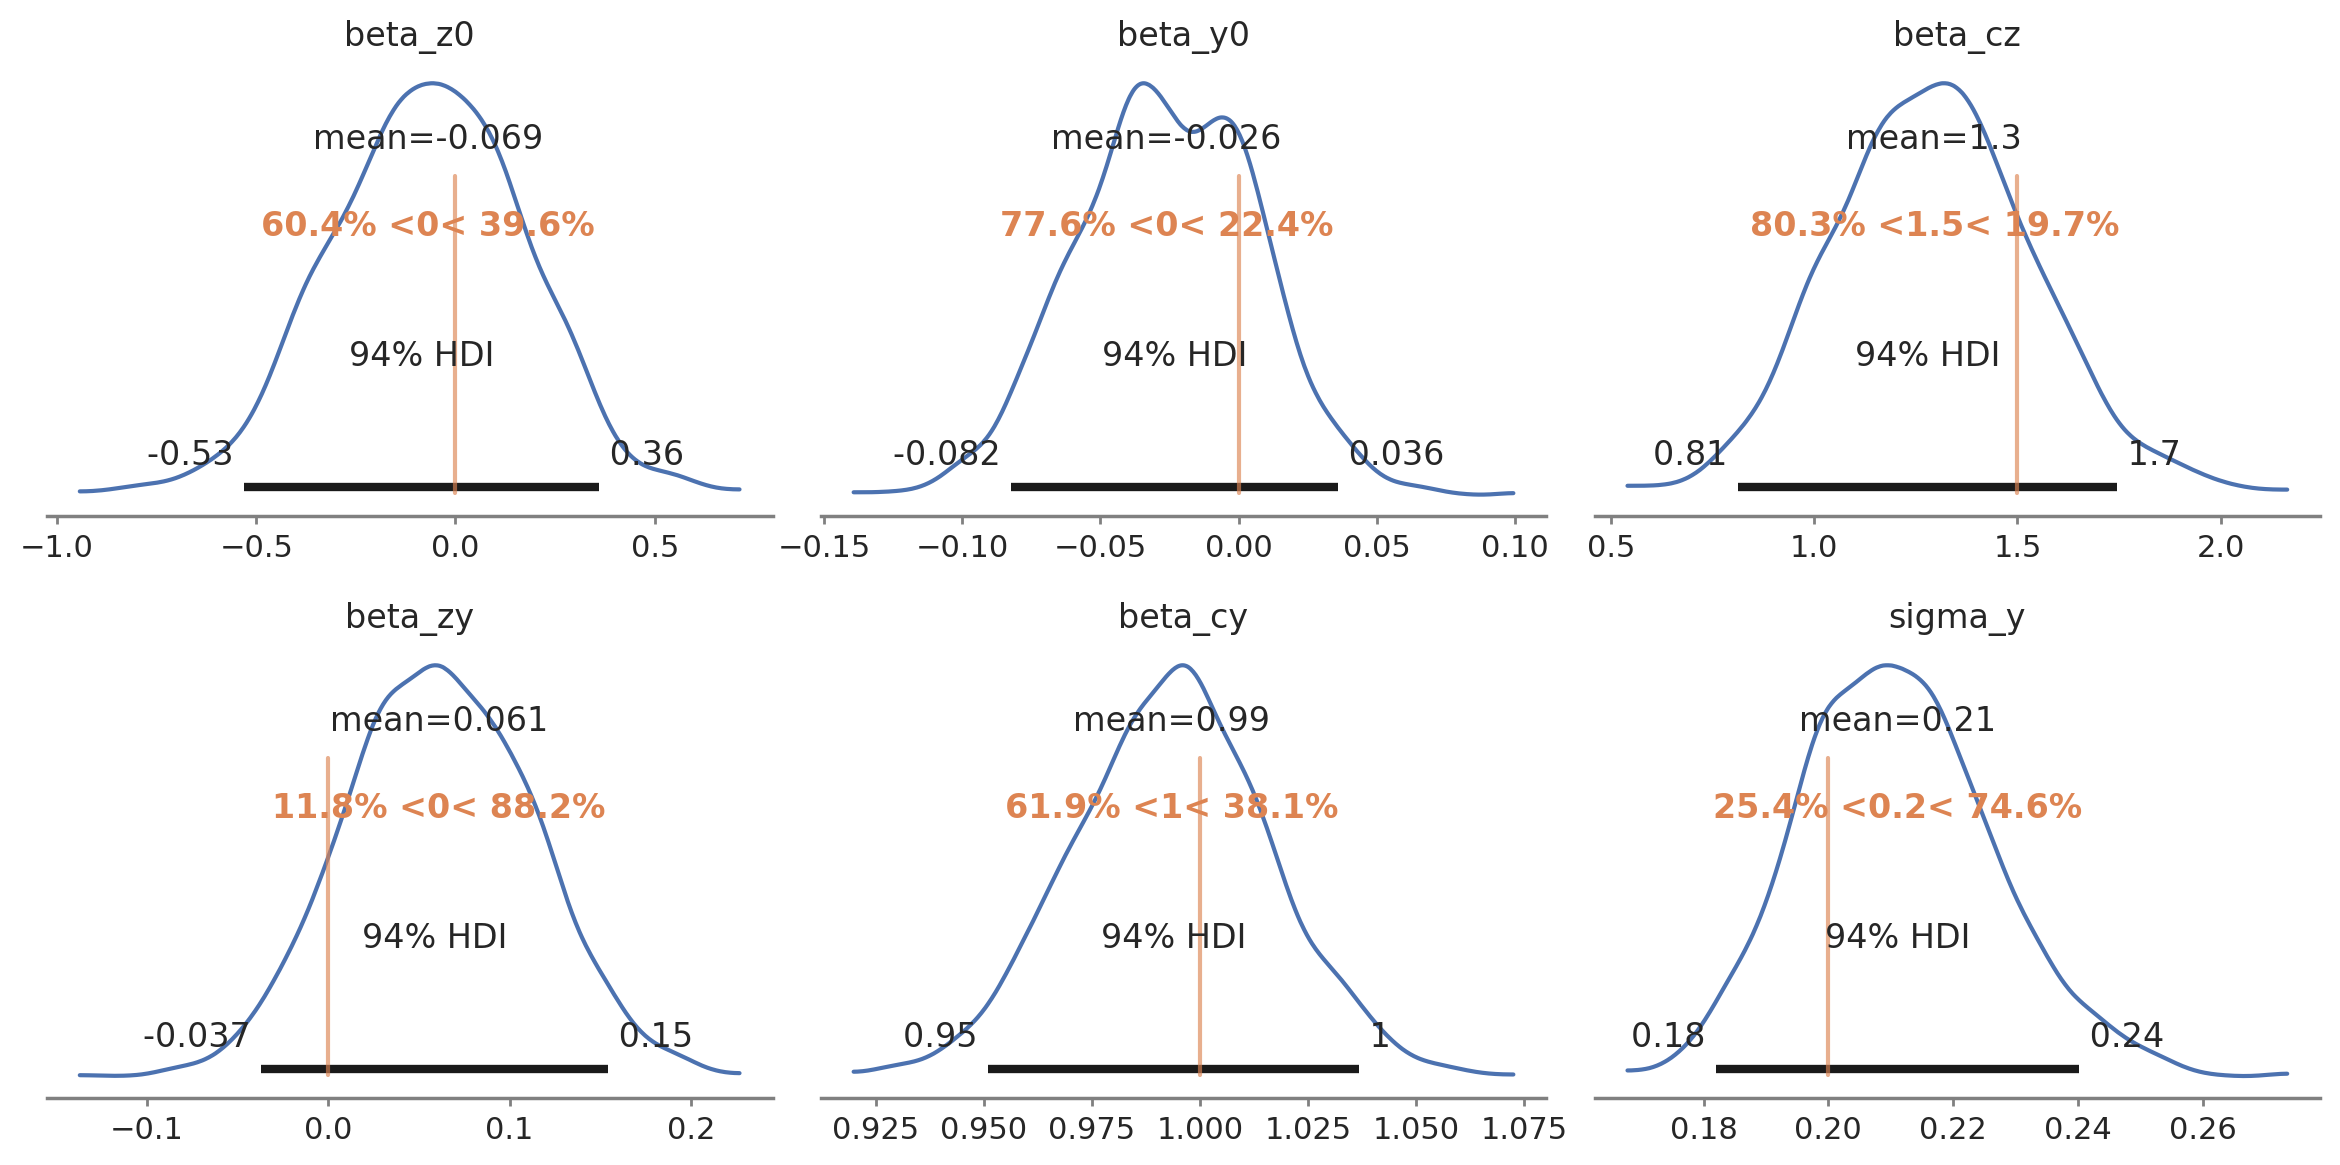

In [13]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

So far we've simply demonstrated that the generative model we wrote can do a good job of recovering the parameters based on data which was generated directly from that data generating process. This can be a very valuable excercise and represents a new Bayesian workflow for those interested in parameter recovery studies. But let's not get distracted by this and return to our causal focus.

## Bayesian Causal Inference - simulating interventions with the new `do` operator.

### 🔥 Counterfactuals 🔥

Now we are ready for the coolest use case for the `do` operator -- doing counterfactual reasoning! This is where we're asking **"What if?"**: *What if* we stopped Google ads? *What if* we increased spending on Google ads? What would we expect our data to look like in these scenarios?

Critically, these hypothetical interventions remove any influence of TV on Google Ads, because the assumption is that we turn Google Ads on and off *irrespective* of what TV is doing. This is the logic behind the `do` operator.

Once we have these two hypotheticals, we estimate the thing we're really interested in: **How strong is the causal influence of Google ads on sales, independent of the TV confounder?**

For those familiar with causal inference, you'll know this as the *Average Treatment Effect*:

$$
ATE = P(Y | c, do(z=1)) -  P(Y | c, do(z=0))
$$

To achieve this in PyMC, we can use the `do()` function again to generate the counterfactual scenarios as explained above. However, before diving in with something like the following:

```python
model_z0 = do(model_inference, {"z": np.zeros(N, dtype="int32")})
```

First, we have to replace the TV RV `c` with its observed data `df["C"]` so that it doesn't get resampled later.

In [14]:
# Replace c with its observed values
model_counterfactual = do(model_inference, {"c": df["c"]})

Now we are able to use the `do()` operator to set all the values of $Z$ to either 0 or 1 to calculate $P(Y | c, do(z=0))$ and $P(Y | c, do(z=1))$, respectively. 

In [15]:
# Generate models with Z=0 and Z=1
model_z0 = do(model_counterfactual, {"z": np.zeros(N, dtype="int32")}, prune_vars=True)
model_z1 = do(model_counterfactual, {"z": np.ones(N, dtype="int32")}, prune_vars=True)

This gives us our two What-If models. As we are interested in what data we would expect to observe under these hypothetical scenarios, we next need to simulate new data for both models.

This is done using our trusted `pm.sample_posterior_predictive()` function which generates new data for given a model and a posterior inference trace (i.e. the `idata` from above when we fit the model to data containing the posteriors of our estimated regression coefficients).

In [16]:
# Sample new sales data assuming Google Ads off: P(Y | c, do(z=0))
idata_z0 = pm.sample_posterior_predictive(
    idata,
    model=model_z0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)
# Sample new sales data assuming Google Ads on: P(Y | c, do(z=1))
idata_z1 = pm.sample_posterior_predictive(
    idata,
    model=model_z1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)

Output()

Output()

Given this hypothetical sales data from the two simulated interventions, we can compute the difference in sales between Google Ads on and off to give us the estimated Average Treatment Effect:

In [17]:
# calculate estimated ATE
ATE_est = idata_z1.predictions - idata_z0.predictions
print(f"Estimated ATE = {ATE_est.y_mu.mean().values:.2f}")

Estimated ATE = 0.06


We get a small but positive ATE. If we didn't know any better, we might be tempted to say that there is indeed a small causal effect of Google Ads on sales.

Fortunately, as the good Bayesians that we are, we know to be weary of point-estimates and always look at the full distribution of outcomes.

In [18]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)

    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")

    # right plot of estimated ATE
    az.plot_posterior(
        idata, var_names="beta_zy", ref_val=true_ATE, round_to=4, ax=ax[1]
    )

    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    ax[1].set(title="Average Treatment Effect")
    plt.tight_layout()

    plt.suptitle(
        "Unit level estimates with do operation,\nand estimate of Average Treatment Effect",
        y=1.05,
    );

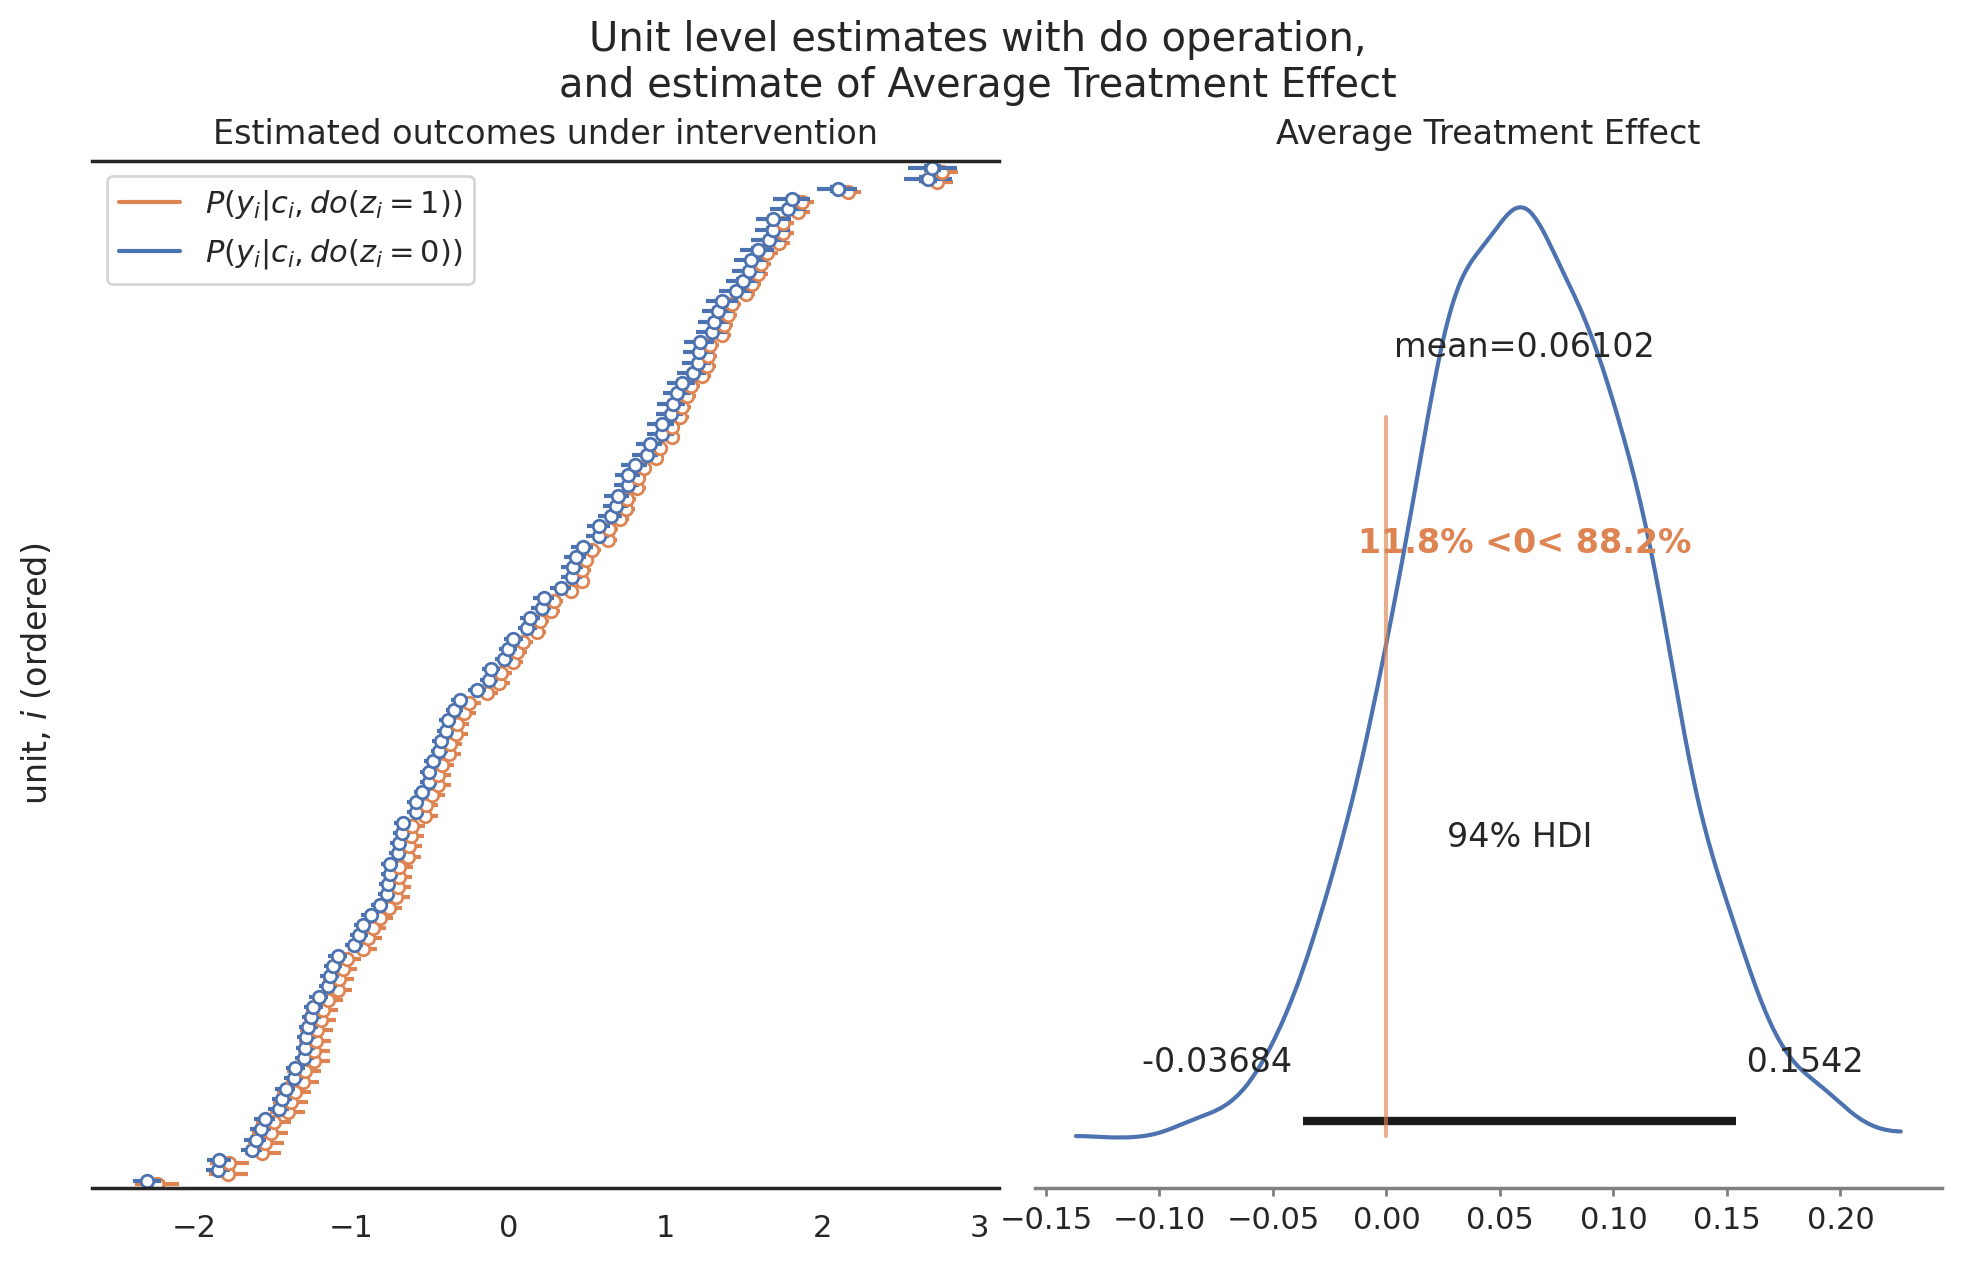

In [19]:
plot_causal_estimates(
    [idata_z0, idata_z1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)

Results of our Bayesian causal inference. The left panel shows our individual level estimates of the outcome $y$ under the counterfactual situations of Google Ads *off* ($\operatorname{do}(z=0)$) or *on* ($\operatorname{do}(z=1)$). Each day (y-axis) has a different outcome due to the influence of the confounding variable, $C$. The right panel shows our posterior estimate of the Average Treatment Effect of $Z \rightarrow Y$. While the ATE distribution is shifted to the right, we see that our uncertainty is nonetheless very high and that 0 is inside the Bayesian credible interval (the black line at the bottom of the right plot).

So is the causal impact of Google Ads on sales large or small? There are many ways we could go about answering this question but here we'll calculate the size of the causal effect of Google Ads on sales ($Z \rightarrow Y$) as a percentage of the causal effect of TV advertising on sales ($C \rightarrow Y$).

In [20]:
percent = (idata.posterior["beta_zy"] / idata.posterior["beta_cy"]) * 100
print(
    f"Causal effect of Google Ads on sales is {percent.mean():.1f}% [{az.hdi(percent).x.data[0]:.1f}%,{az.hdi(percent).x.data[1]:.1f}%] of the effect of TV on sales"
)

Causal effect of Google Ads on sales is 6.2% [-3.9%,15.6%] of the effect of TV on sales


Despite a positive point-estimate of the ATE, we maybe don't conclude that the effect of Google Ads on sales is that high, if there is one at all.

As this example has hopefully demonstrated, Bayesian statistics is the perfect framework for doing causal analysis, and the `do` operator is an enormously helpful tool.

## Summary

### Interpretation

In this blog post we have used an example from marketing analytics to show how easy it is to get fooled by correlation. While it clearly looked like Google Ads were increasing sales, this difference was entirely driven by the TV confounder. This insight became quite obvious when we simulated data under two hypothetical interventions: manually turning Google Ads on and off (which removed the influence of TV on Google Ads).

If we hadn't taken a causal approach, we might have well told the marketing team that increasing Google Ad spend is a good way to boost sales.

In addition, we have shown how even with a causal approach, it is easy to get fooled by randomness. As we're always estimating causal effects from data, point estimates give us no sense of uncertainty. By embedding our causal analysis in a Bayesian framework we are able to use probabilities to quantify how certain we are of there being a causal effect.

Causal models can be easily expressed in PyMC. We simply implement the Data Generating Process and hit the Inference Button. Combined with the newly added do() operator, we are able to simulate interventions that take causality as well as uncertainty into account.

### Extending to More Complex Models

Confounders are a big concern, especially in marketing analytics. While the example used here is realistic, it's definitely also quite simplistic. Usually we would consider not just two marketing channels, but many. In that case, the story becomes more complex, but we still can leverage our understanding of underlying causal structure: marketing channels higher up the funnel are more for brand-building and exhibit longer-term effects, while lower-funnel channels have more direct short-term effects.

Here is a diagram that illustrates this idea:
![funnel.png](funnel.png)

As you can see, higher-funnel **brand marketing spend** (e.g. TV) is building awareness which drives interest which ultimately creates sales. Lower-funnel **performance marketing spend** (e.g. paid search ads) has a more direct influence on sales. Notably, we have all kinds of other factors and confounders as well here we can include as well. For example, we know that price plays a big role on sales, so this allows us to bridge MMMs with price elasticity modeling.

Other real-world effects can be included as well, like channel saturation and delay (adstock) effects. Including these effects into our model turns it into the well-known [Media Mix Model (MMM)](https://www.pymc-labs.io/blog-posts/bayesian-media-mix-modeling-for-marketing-optimization/) which we've done a lot of work on at PyMC Labs, such as [adding time-varying parameters](https://www.pymc-labs.io/blog-posts/modelling-changes-marketing-effectiveness-over-time/). This work culminated into releasing an open-source package to put Bayesian MMMs and customer lifetime value models in PyMC at your fingertips: https://www.pymc-marketing.io.

If this of interest to you, we have built a causal full-funnel Bayesian MMM that includes price-elasticity and are excited to show it around. [Get in touch, we are looking forward to hearing from you](mailto:info@pymc-labs.com).

### From Predictions to Decision Intelligence

**If we want to make better decisions, we need a solid understanding of how our actions affect outcomes. This is the domain of causal analysis.**

**If we don't want to be fooled by the randomness in our data, we need to know how confident we are in our results. This is the domain of Bayesian statistics.**

Combining these two gives us a very powerful framework for doing data science that provides actual business value. As we leave the domain of pure associations or predictions, we stop merely providing insight into what has happened or will happen, but also what to *do* to maximize chances of a favorable outcome. We enter the domain of *Decision Intelligence*.

With the new functionality presented here, PyMC emerges as a powerful tool to aid in this endeavour. 

![](meme.png)

## Technical details

If you are hungry for even more detail, we've got you covered!

* You can find the notebook version of this blogpost [here](https://github.com/pymc-labs/research/blob/main/blog-posts/do_operator/do_operator_blogpost.ipynb).
* And you can find an in-depth yet accessible example of using the do operator to calculate interventional distributions [here](https://www.pymc.io/projects/examples/en/latest/causal_inference/interventional_distribution.html).

## Further reading
* Glymour, M., Pearl, J., & Jewell, N. P. (2016). [Causal inference in statistics: A primer](https://www.wiley.com/en-us/Causal+Inference+in+Statistics%3A+A+Primer-p-9781119186847). John Wiley & Sons.
* Pearl, J. & Mackenzie, D. (2018). [The book of why: the new science of cause and effect](https://en.wikipedia.org/wiki/The_Book_of_Why). Basic books.
* Pearl, J. (2009). [Causality](https://en.wikipedia.org/wiki/Causality_(book)). Cambridge University Press
* Talebi, S. (2022) [Causal Effects via the Do-operator](https://towardsdatascience.com/causal-effects-via-the-do-operator-5415aefc834a).
* [Causal inference in statistics: A primer](https://www.wiley.com/en-us/Causal+Inference+in+Statistics%3A+A+Primer-p-9781119186847).
* Blog post on [Out of model predictions with PyMC](https://www.pymc-labs.io/blog-posts/out-of-model-predictions-with-pymc/)
* For the related approach of quasi-experimentation, check out [`CausalPy`](https://causalpy.readthedocs.io/en/latest/), a package we put together for causal inference in situations, built on top of PyMC (also see our [video from PyData Global 2022](https://youtu.be/gV6wzTk3o1U) about this topic).